In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
#Importing the dataset
df = pd.read_csv("./tripadvisor_hotel_reviews.csv")
# look the data set
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
import ssl

In [9]:
import re
def text_preprocessing(a):
  a = re.sub('[^a-zA-Z]',' ', a)
  a = a.lower().split()
  ps = PorterStemmer()
  clean_word = [ps.stem(i) for i in a if not i in sw]
  sen = ' '.join(clean_word)
  return sen

In [13]:
sw = set(stopwords.words('english'))
df['clean_word']=df["Review"].apply(text_preprocessing)
df = df[['clean_word', 'Rating']]

# Ubah Rating menjadi kategori sentimen (misal: 1-2 = negatif, 3 = netral, 4-5 = positif)
def categorize_sentiment(rating):
    if rating <= 2:
        return 0  # Negatif
    elif rating == 3:
        return 1  # Netral
    else:
        return 2  # Positif

df['Sentiment'] = df['Rating'].apply(categorize_sentiment)
df.head()

,clean_word,Rating,Sentiment
0,nice hotel expens park got good deal stay hote...,4,2
1,ok noth special charg diamond member hilton de...,2,0
2,nice room experi hotel monaco seattl good hote...,3,1
3,uniqu great stay wonder time hotel monaco loca...,5,2
4,great stay great stay went seahawk game awesom...,5,2


In [21]:
dataset = df.sample(frac=1, random_state=42)

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

Train set shape: (16392, 3)
Test set shape: (4099, 3)


In [40]:
class HotelDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = 256

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['clean_word']
        labels = self.data.iloc[index][['Sentiment']].values.astype(int)
        encoding = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        input_ids = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]
        # resize the tensors to the same size
        input_ids = nn.functional.pad(input_ids, (0, self.max_length - input_ids.shape[0]), value=0)
        attention_mask = nn.functional.pad(attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0)
        return input_ids, attention_mask, torch.tensor(labels)

In [41]:
model_checkpoint = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
device = torch.device("mps")

train_dataset = HotelDataset(train_data, tokenizer)
test_dataset = HotelDataset(test_data, tokenizer)

In [42]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
class BertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_checkpoint)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels)

        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs['last_hidden_state'][:, 0, :]
        x = self.classifier(x)
        return x

In [44]:
num_labels = 3
model = BertClassifier(num_labels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)

num_epochs = 5
n_total_steps = len(train_loader)

In [45]:
for epoch in range(num_epochs):

  for i, batch in enumerate (train_loader):

    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)

    attention_mask = attention_mask.to(device)

    labels = labels.view(-1)
    labels = labels.to(device)

    optimizer.zero_grad()

    logits = model(input_ids, attention_mask)

    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()


    if (i+1) % 100 == 0:
        print(f'epoch {epoch + 1}/ {num_epochs}, batch {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

epoch 1/ 5, batch 100/513, loss = 0.8360
epoch 1/ 5, batch 200/513, loss = 0.5035
epoch 1/ 5, batch 300/513, loss = 0.2781
epoch 1/ 5, batch 400/513, loss = 0.5897
epoch 1/ 5, batch 500/513, loss = 0.5028
epoch 2/ 5, batch 100/513, loss = 0.4583
epoch 2/ 5, batch 200/513, loss = 0.2919
epoch 2/ 5, batch 300/513, loss = 0.3001
epoch 2/ 5, batch 400/513, loss = 0.3422
epoch 2/ 5, batch 500/513, loss = 0.1987
epoch 3/ 5, batch 100/513, loss = 0.1611
epoch 3/ 5, batch 200/513, loss = 0.1746
epoch 3/ 5, batch 300/513, loss = 0.1176
epoch 3/ 5, batch 400/513, loss = 0.1799
epoch 3/ 5, batch 500/513, loss = 0.4602
epoch 4/ 5, batch 100/513, loss = 0.0395
epoch 4/ 5, batch 200/513, loss = 0.0657
epoch 4/ 5, batch 300/513, loss = 0.1392
epoch 4/ 5, batch 400/513, loss = 0.1549
epoch 4/ 5, batch 500/513, loss = 0.1433
epoch 5/ 5, batch 100/513, loss = 0.0609
epoch 5/ 5, batch 200/513, loss = 0.0272
epoch 5/ 5, batch 300/513, loss = 0.2682
epoch 5/ 5, batch 400/513, loss = 0.1067
epoch 5/ 5, batc

In [48]:
all_labels = []
all_preds = []

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for i, batch in enumerate (test_loader):

    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)

    attention_mask = attention_mask.to(device)

    labels = labels.view(-1)
    labels = labels.to(device)

    outputs = model(input_ids, attention_mask)

    _, predictions = torch.max(outputs, 1)

    all_labels.append(labels.cpu().numpy())
    all_preds.append(predictions.cpu().numpy())

all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

print(classification_report(all_labels, all_preds, target_names=["Negatif", "Netral", "Positif"]))
print(accuracy_score(all_labels, all_preds))

              precision    recall  f1-score   support

     Negatif       0.80      0.79      0.79       661
      Netral       0.41      0.45      0.43       435
     Positif       0.94      0.93      0.93      3003

    accuracy                           0.86      4099
   macro avg       0.72      0.72      0.72      4099
weighted avg       0.86      0.86      0.86      4099

0.8555745303732618


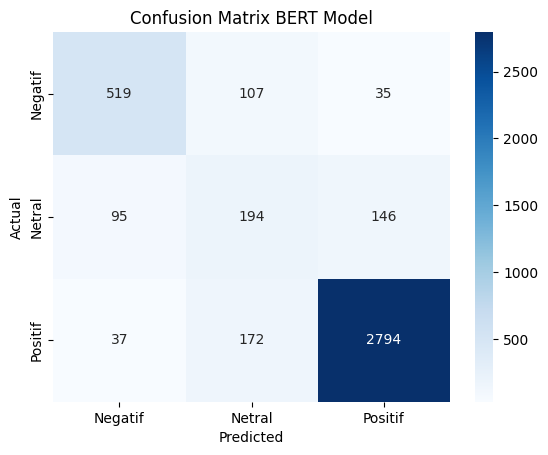

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negatif", "Netral", "Positif"], yticklabels=["Negatif", "Netral", "Positif"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix BERT Model')
plt.show()

In [57]:
import torch

# Simpan model
torch.save(model, "bert/bert_full_model.pt") 

# Simpan tokenizer
tokenizer.save_pretrained("bert/bert_tokenizer")

('bert/bert_tokenizer/tokenizer_config.json',
 'bert/bert_tokenizer/special_tokens_map.json',
 'bert/bert_tokenizer/vocab.txt',
 'bert/bert_tokenizer/added_tokens.json')

In [62]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn

# Class ulang harus didefinisikan dulu
class BertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs['last_hidden_state'][:, 0, :]
        x = self.classifier(x)
        return x

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert/bert_tokenizer")

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier(num_labels=3)
model.load_state_dict(torch.load("bert/bert_full_model.pt", map_location=device))
model.to(device)
model.eval()


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [71]:
def predict_review(review_text):
    # Tokenisasi input review
    inputs = tokenizer(review_text, return_tensors="pt", padding=True, truncation=True, max_length=256)

    # Pindahkan input ke device (GPU/CPU)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Prediksi dengan model
    with torch.no_grad():
        output = model(input_ids, attention_mask)

    # Ambil hasil prediksi kelas (label) dari output
    _, predicted_class = torch.max(output, dim=1)

    # Tampilkan hasil prediksi
    sentiment_labels = ["Negatif", "Netral", "Positif"]
    predicted_sentiment = sentiment_labels[predicted_class.item()]

    return predicted_sentiment